# ViT Visual Working Memory Experiment

This notebook replicates the original `vit_vwm.py` workflow using the refactored `vwm` package.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

# Mount Google Drive (if using Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Import from the vwm package
from vit_vwm.config import set_seed
from vit_vwm.stimuli import get_batch
from vit_vwm.dataset import create_dataloader, VWMDataLoader
from vit_vwm.models import ViT_control, ViT_attention_bottleneck
from vit_vwm.losses import circular_loss, degrees_error
from vit_vwm.training import train_model, collect_model_data
from vit_vwm.analysis import get_zhang_luck_params
from vit_vwm.visualization import (
    unnormalize,
    plot_mixture_distributions,
    plot_zhang_luck_results,
    visualize_attention
)

In [3]:
from vit_vwm.config import set_seed, get_device

set_seed(42)
device = get_device()
print(f"Running on device: {device}")

Running on device: mps


# Stimulus Generation

## Sample Display

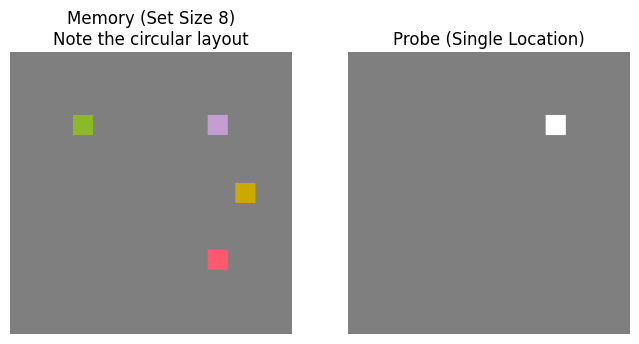

In [4]:
# Generate a "Full Load" batch (Set Size 8) to see all positions
m_batch, p_batch, _, _ = get_batch(1, set_size=4)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(unnormalize(m_batch[0]))
plt.title("Memory (Set Size 8)\nNote the circular layout")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unnormalize(p_batch[0]))
plt.title("Probe (Single Location)")
plt.axis('off')

plt.show()

# Model Architecture

## Retinotopic ViT-VWM

To simulate the cognitive process of visual working memory—specifically the binding of identity (orientation) to spatial location—we developed a **Siamese ViT-Encoder / Cross-Attention Decoder** architecture.

This design addresses the "Binding Problem" by explicitly separating the **storage** of visual information (Memory Display) from the **retrieval** cue (Probe Display), interacting only through a bottlenecked attention mechanism.

#### **1. Shared Backbone (Siamese Encoder)**

Both the *Memory Display* (the set of colored bars) and the *Probe Display* (the spatial cue) are processed independently by the same **ViT-Base/16** backbone.

* **Siamese Weight Sharing:** This ensures that the "visual language" used to encode the memory items is identical to the language used to encode the retrieval cue.
* **Partial Fine-Tuning Strategy:** To balance robust feature extraction with task-specific adaptation:
* **Blocks 0–10 (Frozen):** Retain ImageNet-21k visual priors (edge detection, texture analysis).
* **Block 11 + LayerNorm (Unfrozen):** Fine-tuned to adapt the attention heads to the sparse geometry of the VWM task, allowing the model to learn specific spatial-feature bindings without catastrophic forgetting.


* **Output:** The encoder outputs a sequence of patch embeddings, preserving the 2D spatial topology of the input (Retinotopic mapping).

#### **2. Attention-Based Retrieval (The "Binding" Mechanism)**

Instead of a standard classifier token (`[CLS]`), we implement a custom **Cross-Attention Decoding Head** that acts as the model's "focus of attention."

* **The Memory Bank ():** The patch embeddings from the *Memory Display* serve as the Keys and Values. This represents the "visuospatial scratchpad" where all items (target + distractors) are held.
* **The Retrieval Query ():** The *Probe Display* features are aggregated (via Global Max Pooling) and projected through a **Probe Adapter** (MLP: Linear  GELU  Linear). This transforms the visual representation of the cue (e.g., "white box at top-left") into a *spatial query vector*.
* **The Operation:** The model computes the dot-product attention between the Probe Query () and all Memory Patches (). The resulting attention weights effectively "select" the specific location in memory requested by the cue, suppressing distractors and extracting the relevant feature vector ().

#### **3. Continuous Readout Head**

To respect the circular topology of the target variable (orientation), we replace the standard Softmax classification head with a **Continuous Regression Head**.

* **Architecture:** The retrieved context vector is passed through a decoding MLP (Linear  ReLU  Linear).
* **Topological Output:** The model predicts a 2-dimensional unit vector .
* **Scientific Justification:** This continuous representation avoids the "boundary cliff" of scalar regression (where  and  are numerically distant). It enables the model to be optimized via **Cosine Similarity Loss**, treating error as a smooth angular distance rather than a categorical mismatch.

---

### **Why this design matters (Summary for paper)**

This architecture is not merely a computer vision model; it is a **functional hypothesis of working memory**. By forcing the model to retrieve information via a limited query-key bottleneck (Cross-Attention), we explicitly model the "spotlight of attention." This structure allows us to test whether the model exhibits human-like failure modes—such as **Precision errors** (noise in the regression head) versus **Swap errors** (attending to the wrong key in the memory bank).

# Model Training

**Stimuli and Dataset Generation**
Training data was generated synthetically via an infinite data stream rather than a fixed static dataset. Stimuli consisted of  pixel images with a grey background.

* **Set Size:** For each trial, set size  was uniformly drawn from  to .
* **Colors:** Target colors were drawn from a circular color space discretized into 180 bins (2° increments). To prevent perceptual ambiguity, colors were sampled **without replacement**, ensuring no two items in a display shared the exact same hue.
* **Locations:** Spatial locations were sampled without replacement from a discrete grid to ensure no spatial overlap between items.

**Task Procedure**
The model performed a retroactive spatial cueing task. It received two simultaneous input tensors:

1. **Memory Display:** Containing  colored squares at random locations.
2. **Probe Display:** Containing a spatial cue (a white outline) at the location of one target item.
The model was required to output the continuous color value (angle in radians) of the item at the probed location.

**Training and Optimization**
The model was trained using the **AdamW** optimizer (learning rate $= 1 \times 10^{-4}$, weight decay $= 1 \times 10^{-2}$) with gradient clipping (max norm $= 1.0$) to maintain stability. The objective function was a **Circular Loss** ($\mathscr{L}$), defined as the cosine distance between the predicted angle  and the target angle : $$\mathscr{L} = 1 - \cos(\hat{\theta} - \theta)$$


To maximize training throughput, we utilized a nested loop structure where one "epoch" consisted of **100 gradient update steps** (batch size $= 64$) followed by a single validation pass. Training proceeded for 300 epochs (approx. 1.9 million samples). A `ReduceLROnPlateau` scheduler reduced the learning rate by a factor of 0.5 if the mean absolute angular error did not improve for 10 consecutive epochs.

In [44]:
# 1. Train
model = ViT_attention_bottleneck().to(device)
trained_model, history = train_model(
    model,
    total_steps=2000,      
    batch_size=128,
    eval_every=10,        
    lr=1e-4,             
    patience=20,           
    device=device,
)

Generating fixed validation sets...
Training: 2000 steps × 128 batch = 256,000 samples
Eval every 10 steps, patience=20


Training:   0%|          | 0/2000 [00:00<?, ?it/s]


Early stop at step 1820: no improvement for 20 evals
Training complete. Best validation error: 34.1°


In [45]:
# 2. Collect Data (Simulate an experiment with 2000 trials)
data = collect_model_data(trained_model, num_trials=2000, device=device)

Collecting:   0%|          | 0/32 [00:00<?, ?it/s]

In [24]:
# Create output directory
save_dir = Path("outputs")
save_dir.mkdir(exist_ok=True)

# 1. MODEL: Save state dict (smaller, more portable)
torch.save(trained_model.state_dict(), save_dir / "vit_vwm_weights.pt")

# To reload later:
# model = BaselineViT_Spatial()
# model.load_state_dict(torch.load("outputs/vit_vwm_weights.pt"))

# 2. HISTORY: Save as pickle (list of dicts)
with open(save_dir / "training_history.pkl", "wb") as f:
    pickle.dump(history, f)

# 3. DATA: Save as pickle (dict of arrays)
with open(save_dir / "experiment_data.pkl", "wb") as f:
    pickle.dump(data, f)

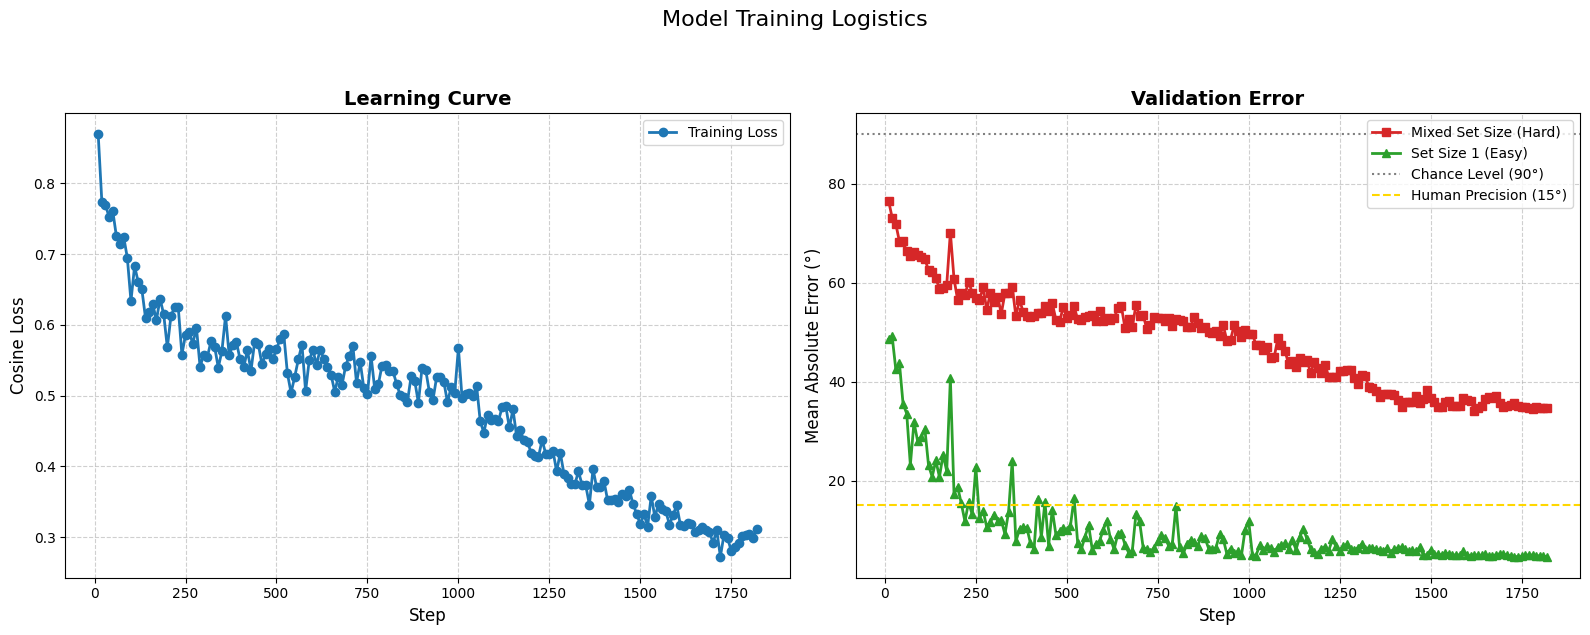

In [46]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(history)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot A: Learning Curve (Loss) ---
ax1.plot(df['step'], df['loss'], marker='o', color='#1f77b4', linewidth=2, label='Training Loss')
ax1.set_title('Learning Curve', fontsize=14, fontweight='bold')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Cosine Loss', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# --- Plot B: Performance (Angular Error) ---
ax2.plot(df['step'], df['err_mix'], marker='s', color='#d62728', linewidth=2, label='Mixed Set Size (Hard)')
ax2.plot(df['step'], df['err_ss1'], marker='^', color='#2ca02c', linewidth=2, label='Set Size 1 (Easy)')

# Add reference lines
ax2.axhline(y=90, color='gray', linestyle=':', label='Chance Level (90°)')
ax2.axhline(y=15, color='gold', linestyle='--', label='Human Precision (15°)')

ax2.set_title('Validation Error', fontsize=14, fontweight='bold')
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Mean Absolute Error (°)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.suptitle('Model Training Logistics', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

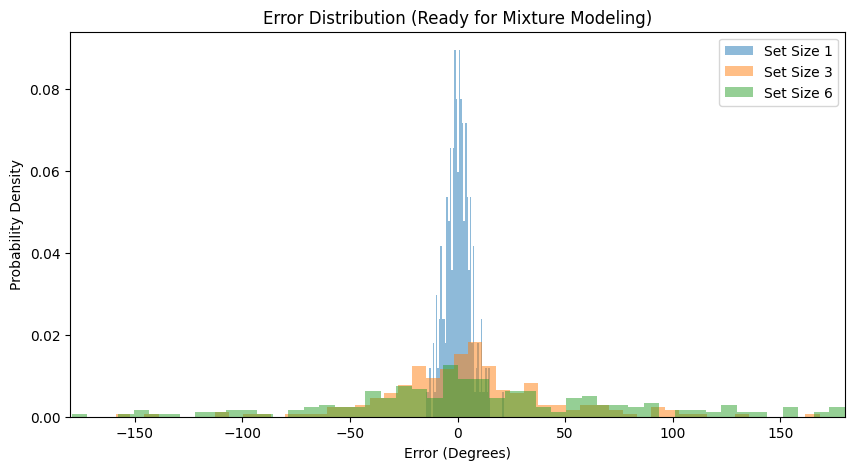

In [47]:
# 3. Quick Verification Plot (Histogram of Errors)
# If the model works, this should look like a "spike" at 0.
# If the model is guessing, it will look like a flat line.
plt.figure(figsize=(10, 5))

# Plot Set Size 1 (Easy)
indices_ss1 = data['set_size'] == 1
plt.hist(data['error_deg'][indices_ss1], bins=50, alpha=0.5, label='Set Size 1', density=True)

# Plot Set Size 3 (Medium)
indices_ss3 = data['set_size'] == 3
plt.hist(data['error_deg'][indices_ss3], bins=50, alpha=0.5, label='Set Size 3', density=True)

# Plot Set Size 6 (Harder)
indices_ss6 = data['set_size'] == 6
plt.hist(data['error_deg'][indices_ss6], bins=50, alpha=0.5, label='Set Size 6', density=True)

plt.xlabel('Error (Degrees)')
plt.ylabel('Probability Density')
plt.title('Error Distribution (Ready for Mixture Modeling)')
plt.legend()
plt.xlim(-180, 180)
plt.show()

# Mixture Modeling

In [48]:
# run analysis
df_params = get_zhang_luck_params(data)

SS  | Pm (Prob Mem)   | s.d. (Precision) | Guess Rate   | Kappa   
-----------------------------------------------------------------
1   | 0.900           |  27.2°          | 0.100        |   5.0
2   | 0.900           |  27.2°          | 0.100        |   5.0
3   | 0.900           |  27.2°          | 0.100        |   5.0
4   | 0.900           |  27.2°          | 0.100        |   5.0
5   | 0.900           |  27.2°          | 0.100        |   5.0
6   | 0.604           |  27.2°          | 0.396        |   5.0
7   | 0.900           |  27.2°          | 0.100        |   5.0
8   | 0.000           |  27.2°          | 1.000        |   5.0


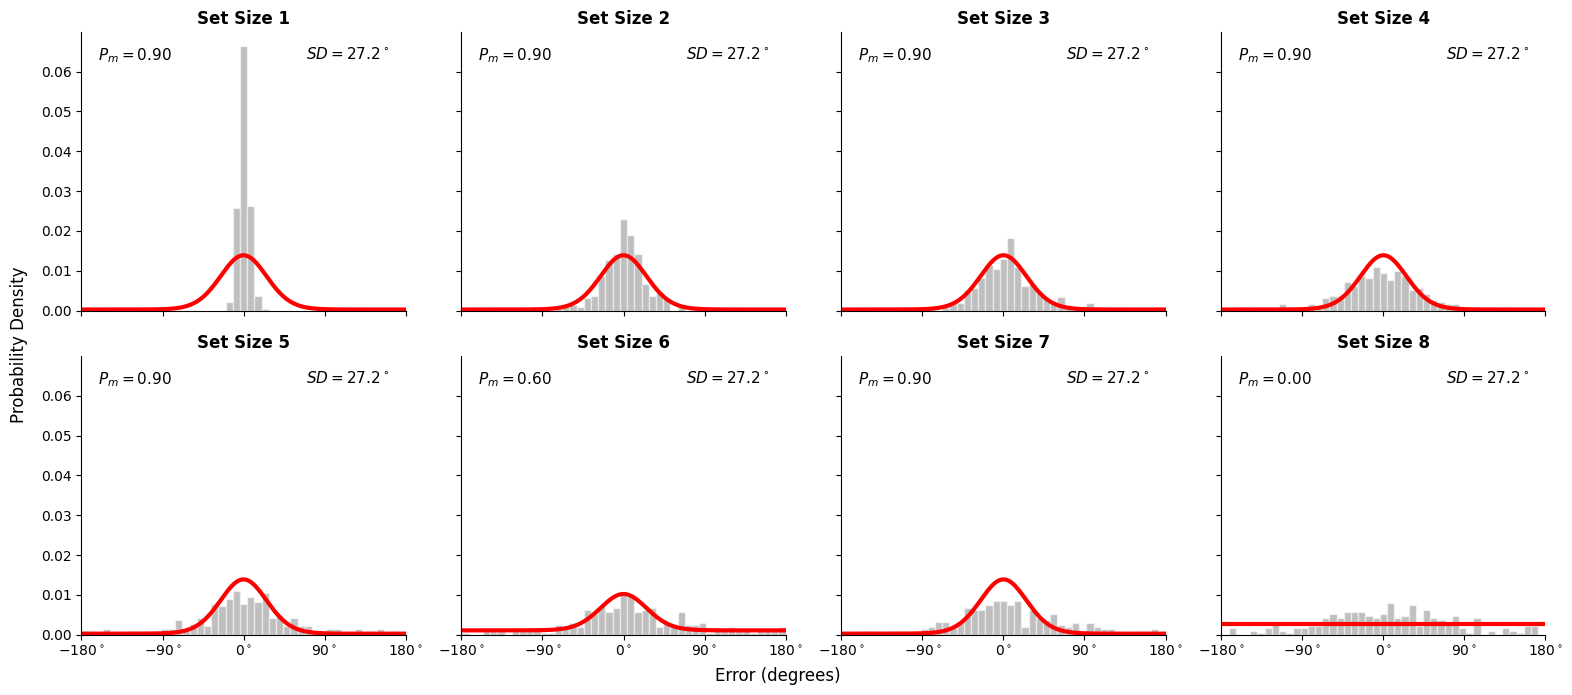

In [49]:
plot_mixture_distributions(data, df_params)

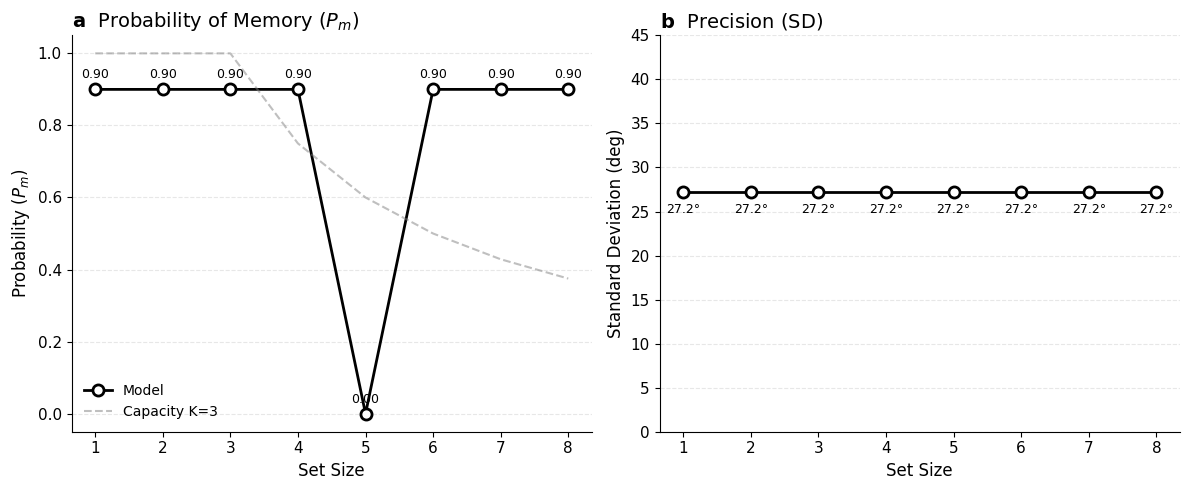

In [30]:
plot_zhang_luck_results(df_params)